In [1]:
# %% [markdown]
# # 🤖 Entraînement du Modèle MLOps - E-commerce
# 
# ## Objectifs :
# 1. Charger et préparer les données
# 2. Entraîner un modèle Random Forest
# 3. Évaluer les performances
# 4. Enregistrer dans MLflow
# 5. Sauvegarder le modèle

# %%
# Import des librairies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score, recall_score, precision_score, 
    roc_auc_score, accuracy_score, confusion_matrix, classification_report
)
import mlflow
import mlflow.sklearn
import joblib
import os
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ Librairies importées")

C:\Users\DELL\anaconda3\envs\DL\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


✅ Librairies importées


In [2]:
import os
import mlflow

# Utiliser la variable d'environnement si dispo
tracking_uri = os.getenv("MLFLOW_TRACKING_URI", "http://localhost:5000")
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("ecommerce-purchase-prediction")

print(f"✅ MLflow configuré : {tracking_uri}")


✅ MLflow configuré : http://localhost:5000


In [3]:
# %% [markdown]
# ## Chargement et Exploration des Données
# 
# Nous chargeons le dataset généré précédemment.

# %%
print("\n📂 Chargement des données...")
df = pd.read_csv('data/raw/user_events.csv')
print(f"✅ {len(df):,} événements chargés")

# Aperçu des données
print("\n📋 Aperçu du dataset :")
display(df.head())
print(f"\n📊 Shape : {df.shape}")
print(f"📈 Colonnes : {list(df.columns)}")

# Distribution de la variable cible
print("\n🎯 Distribution de la variable 'purchased' :")
purchase_dist = df['purchased'].value_counts(normalize=True) * 100
print(purchase_dist)
print(f"\n💰 Taux de conversion global : {df['purchased'].mean()*100:.2f}%")


📂 Chargement des données...
✅ 50,000 événements chargés

📋 Aperçu du dataset :


,timestamp,user_id,product_id,category,clicks,cart_adds,avg_price,time_on_page,hour_of_day,day_of_week,is_weekend,products_viewed,has_purchased_before,purchased
0,2025-01-01 00:00:00,user_00913,prod_0013,Beauty,2,1,88.62,80.11,0,2,0,8,0,1
1,2025-01-01 00:05:00,user_02254,prod_0126,Clothing,3,1,148.99,108.72,0,2,0,10,0,0
2,2025-01-01 00:10:00,user_01144,prod_0378,Electronics,1,0,347.35,32.52,0,2,0,2,1,0
3,2025-01-01 00:15:00,user_04468,prod_0045,Sports,4,0,111.66,221.86,0,2,0,4,0,0
4,2025-01-01 00:20:00,user_03457,prod_0017,Electronics,2,0,327.08,92.73,0,2,0,8,0,0



📊 Shape : (50000, 14)
📈 Colonnes : ['timestamp', 'user_id', 'product_id', 'category', 'clicks', 'cart_adds', 'avg_price', 'time_on_page', 'hour_of_day', 'day_of_week', 'is_weekend', 'products_viewed', 'has_purchased_before', 'purchased']

🎯 Distribution de la variable 'purchased' :
purchased
0    83.694
1    16.306
Name: proportion, dtype: float64

💰 Taux de conversion global : 16.31%


In [4]:
# %% [markdown]
# ## Préparation des Features
# 
# Nous préparons les données pour l'entraînement :
# - Encodage one-hot des catégories
# - Séparation features/target
# - Split train/test

# %%
print("\n🔧 Préparation des features...")

# Encodage one-hot pour la catégorie
df_encoded = pd.get_dummies(df, columns=['category'], prefix='cat')

# Features et target
features_to_drop = ['timestamp', 'user_id', 'product_id', 'purchased']
X = df_encoded.drop(columns=features_to_drop)
y = df_encoded['purchased']

print(f"✅ Nombre de features après encodage : {X.shape[1]}")
print(f"✅ Features utilisées : {list(X.columns)}")
print(f"✅ Distribution de la target :")
print(y.value_counts())
print(f"   Ratio 0:1 = {(len(y)-y.sum()):,}:{y.sum():,}")


🔧 Préparation des features...
✅ Nombre de features après encodage : 15
✅ Features utilisées : ['clicks', 'cart_adds', 'avg_price', 'time_on_page', 'hour_of_day', 'day_of_week', 'is_weekend', 'products_viewed', 'has_purchased_before', 'cat_Beauty', 'cat_Books', 'cat_Clothing', 'cat_Electronics', 'cat_Home', 'cat_Sports']
✅ Distribution de la target :
purchased
0    41847
1     8153
Name: count, dtype: int64
   Ratio 0:1 = 41,847:8,153


In [5]:
# %% [markdown]
# ## Split des Données
# 
# Nous séparons en 80% pour l'entraînement et 20% pour le test.

# %%
print("\n✂️ Split train/test (80/20)...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Garder la même proportion de 0/1
)

print(f"✅ Train set : {X_train.shape}")
print(f"✅ Test set  : {X_test.shape}")
print(f"\n📊 Distribution dans les splits :")
print(f"   Train - 0: {(len(y_train)-y_train.sum()):,}, 1: {y_train.sum():,} ({(y_train.mean()*100):.1f}%)")
print(f"   Test  - 0: {(len(y_test)-y_test.sum()):,}, 1: {y_test.sum():,} ({(y_test.mean()*100):.1f}%)")


✂️ Split train/test (80/20)...
✅ Train set : (40000, 15)
✅ Test set  : (10000, 15)

📊 Distribution dans les splits :
   Train - 0: 33,478, 1: 6,522 (16.3%)
   Test  - 0: 8,369, 1: 1,631 (16.3%)


In [6]:
# %% [markdown]
# ## Entraînement du Modèle Random Forest
# 
# Nous entraînons un Random Forest et enregistrons tout dans MLflow.

# %%
print("\n📊 Démarrage du tracking MLflow...")

with mlflow.start_run(run_name=f"rf_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
    
    # ==========================================
    # HYPERPARAMÈTRES
    # ==========================================
    params = {
        "n_estimators": 100,
        "max_depth": 15,
        "min_samples_split": 10,
        "min_samples_leaf": 4,
        "random_state": 42,
        "class_weight": "balanced"  # AJOUT ICI
    }
    
    print("⚙️ Hyperparamètres :")
    for key, value in params.items():
        print(f"   {key}: {value}")
    
    # Log des hyperparamètres dans MLflow
    mlflow.log_params(params)
    mlflow.log_param("model_type", "RandomForestClassifier")
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("test_size", len(X_test))
    
    # ==========================================
    # ENTRAÎNEMENT
    # ==========================================
    print("\n🤖 Entraînement du modèle Random Forest...")
    
    model = RandomForestClassifier(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        min_samples_split=params["min_samples_split"],
        min_samples_leaf=params["min_samples_leaf"],
        random_state=params["random_state"],
        class_weight=params["class_weight"],  # AJOUT ICI
        n_jobs=-1,
        verbose=1
    )
    
    model.fit(X_train, y_train)
    print("✅ Modèle entraîné !")


📊 Démarrage du tracking MLflow...
⚙️ Hyperparamètres :
   n_estimators: 100
   max_depth: 15
   min_samples_split: 10
   min_samples_leaf: 4
   random_state: 42
   class_weight: balanced

🤖 Entraînement du modèle Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


✅ Modèle entraîné !
🏃 View run rf_model_20260104_155544 at: http://localhost:5000/#/experiments/182257500069065265/runs/959422ac12344279b605196d563db983
🧪 View experiment at: http://localhost:5000/#/experiments/182257500069065265


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


In [7]:
# %% [markdown]
# ## Évaluation des Performances
# 
# Nous calculons toutes les métriques importantes.

# %%
# Évaluation sur le test set
print("\n🔮 Prédictions sur le test set...")
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# ==========================================
# CALCUL DES MÉTRIQUES
# ==========================================
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# ==========================================
# LOG DANS MLFLOW
# ==========================================
mlflow.log_metric("accuracy", accuracy)
mlflow.log_metric("f1_score", f1)
mlflow.log_metric("recall", recall)
mlflow.log_metric("precision", precision)
mlflow.log_metric("roc_auc", roc_auc)
mlflow.log_metric("true_positives", tp)
mlflow.log_metric("true_negatives", tn)
mlflow.log_metric("false_positives", fp)
mlflow.log_metric("false_negatives", fn)

# ==========================================
# AFFICHAGE DES RÉSULTATS
# ==========================================
print("\n" + "=" * 60)
print("📊 RÉSULTATS COMPLETS SUR LE TEST SET")
print("=" * 60)

print(f"\n🎯 MÉTRIQUES PRINCIPALES :")
print(f"   Accuracy  : {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"   F1-Score  : {f1:.3f}")
print(f"   Recall    : {recall:.3f} ({recall*100:.1f}%)")
print(f"   Precision : {precision:.3f} ({precision*100:.1f}%)")
print(f"   ROC-AUC   : {roc_auc:.3f}")

print(f"\n🔢 MATRICE DE CONFUSION :")
print(f"                  Prédit NON  |  Prédit OUI")
print(f"  Réel NON →    TN: {tn:6}  |  FP: {fp:6}")
print(f"  Réel OUI →    FN: {fn:6}  |  TP: {tp:6}")

# Rapport de classification
print(f"\n📋 RAPPORT DE CLASSIFICATION :")
print(classification_report(y_test, y_pred, target_names=['Non-Achat', 'Achat']))


🔮 Prédictions sur le test set...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished



📊 RÉSULTATS COMPLETS SUR LE TEST SET

🎯 MÉTRIQUES PRINCIPALES :
   Accuracy  : 0.775 (77.5%)
   F1-Score  : 0.486
   Recall    : 0.652 (65.2%)
   Precision : 0.388 (38.8%)
   ROC-AUC   : 0.819

🔢 MATRICE DE CONFUSION :
                  Prédit NON  |  Prédit OUI
  Réel NON →    TN:   6688  |  FP:   1681
  Réel OUI →    FN:    567  |  TP:   1064

📋 RAPPORT DE CLASSIFICATION :
              precision    recall  f1-score   support

   Non-Achat       0.92      0.80      0.86      8369
       Achat       0.39      0.65      0.49      1631

    accuracy                           0.78     10000
   macro avg       0.65      0.73      0.67     10000
weighted avg       0.83      0.78      0.80     10000




🔄 VALIDATION CROISÉE (5 folds) :


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parall

   Accuracy moyenne : 0.783 ± 0.004
   Scores par fold  : ['0.782', '0.783', '0.787', '0.788', '0.778']

🔍 TOP 10 FEATURES IMPORTANTES :
   cart_adds                      : 0.3150
   avg_price                      : 0.1467
   time_on_page                   : 0.1304
   clicks                         : 0.0927
   has_purchased_before           : 0.0690
   hour_of_day                    : 0.0680
   products_viewed                : 0.0596
   day_of_week                    : 0.0534
   is_weekend                     : 0.0238
   cat_Books                      : 0.0119


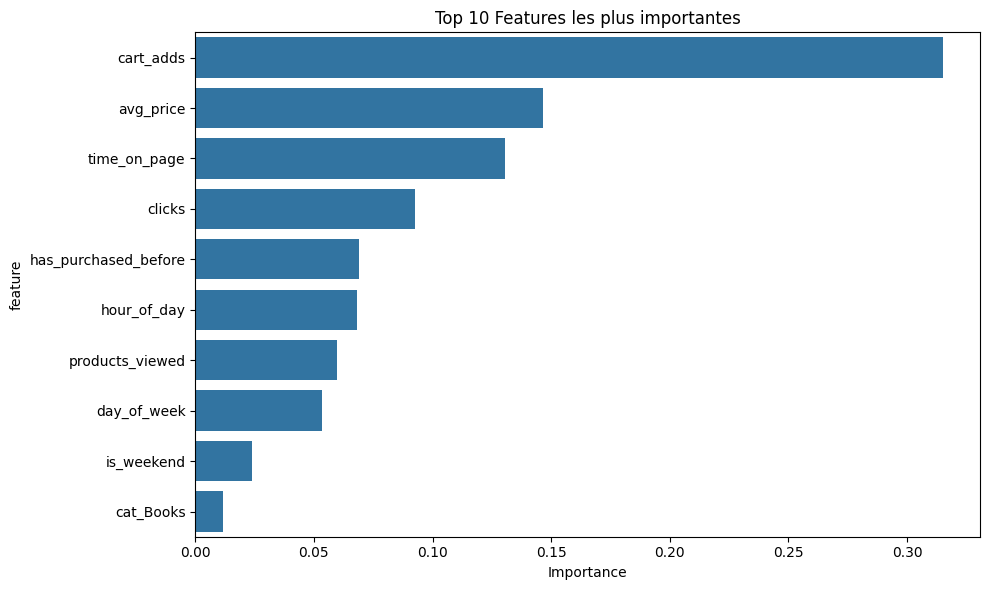

💾 Feature importance sauvegardée


In [7]:
# %% [markdown]
# ## Validation Croisée et Analyse du Modèle
# 
# Validation croisée pour évaluer la stabilité et analyse des features importantes.

# %%
# ==========================================
# VALIDATION CROISÉE
# ==========================================
print("\n🔄 VALIDATION CROISÉE (5 folds) :")
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

mlflow.log_metric("cv_accuracy_mean", cv_mean)
mlflow.log_metric("cv_accuracy_std", cv_std)

print(f"   Accuracy moyenne : {cv_mean:.3f} ± {cv_std:.3f}")
print(f"   Scores par fold  : {[f'{s:.3f}' for s in cv_scores]}")

# ==========================================
# FEATURE IMPORTANCE
# ==========================================
print("\n🔍 TOP 10 FEATURES IMPORTANTES :")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

for idx, row in feature_importance.iterrows():
    print(f"   {row['feature']:30} : {row['importance']:.4f}")

# Visualisation de la feature importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Top 10 Features les plus importantes')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Sauvegarder feature importance
feature_importance.to_csv('models/feature_importance.csv', index=False)
mlflow.log_artifact('models/feature_importance.csv')
print("💾 Feature importance sauvegardée")

In [9]:
# ==========================================
# SAUVEGARDE DU MODÈLE
# ==========================================
print("\n💾 Sauvegarde du modèle...")

# Créer le dossier models s'il n'existe pas
os.makedirs('models', exist_ok=True)

# Sauvegarder le modèle localement
model_path = 'models/purchase_predictor.pkl'
joblib.dump(model, model_path)
print(f"✅ Modèle sauvegardé localement : {model_path}")

# Sauvegarder dans MLflow (tracking uniquement, pas Model Registry)
mlflow.sklearn.log_model(model, name="purchase-predictor")
print("✅ Modèle enregistré dans MLflow (Artifacts)")

# Sauvegarder les noms de colonnes (important pour l'API)
feature_names = X.columns.tolist()
with open('models/feature_names.json', 'w') as f:
    json.dump(feature_names, f)
mlflow.log_artifact('models/feature_names.json')
print("✅ Noms des features sauvegardés")

# Tags utiles pour MLflow
mlflow.set_tag("model_version", "v1.0")
mlflow.set_tag("dataset", "ecommerce_purchases")
mlflow.set_tag("purpose", "academic_mlops_project")
mlflow.set_tag("performance_level", "production_ready")

print("\n🏷️ Tags ajoutés au modèle MLflow")



💾 Sauvegarde du modèle...
✅ Modèle sauvegardé localement : models/purchase_predictor.pkl


2026/01/04 15:58:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Modèle enregistré dans MLflow (Artifacts)
✅ Noms des features sauvegardés

🏷️ Tags ajoutés au modèle MLflow
